## Name: Shivkumar G. Chauhan
### Roll No.: CS8A53
### Batch A-3
---
# Experiment - 8 : Implement time series forecasting.

## imports

In [343]:
import pandas
import numpy
import warnings
import matplotlib.pyplot as pyplot
import scipy.stats
from sklearn.metrics import mean_squared_error,mean_absolute_error
import datetime
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.stattools
import statsmodels.graphics.tsaplots

## Configurations

In [228]:
# %matplotlib qt
%matplotlib inline
pyplot.rcParams["figure.figsize"] = (15, 12)

hiding warnings

In [170]:
warnings.filterwarnings('ignore')

Initializing Functions

In [14]:
def PreprocessTheCovidData(Main_Data:pandas.DataFrame,Selected_columns:list,isCumulative=False)->pandas.DataFrame:
    """Final Function for Whole Data Processing for Covid Data

    Args:
        Main_Data (pandas.DataFrame): Initial Raw Data
        Selected_columns (list): list of columns that to bet selected

    Returns:
        pandas.DataFrame: Preprocessed Data
    """
    Main_Data=Main_Data[Selected_Columns]
    if isCumulative:
        for index in Main_Data['location'].value_counts().index:
            if len(Main_Data[Main_Data['location']==index]['total_cases'].unique())<2:
                Main_Data=Main_Data[Main_Data['location']!=index]
    for index in Main_Data[Main_Data['continent'].isnull()==True]['location'].value_counts().index:
        if index.find("income")!=-1:
            Main_Data[Main_Data['location']==index]=Main_Data[Main_Data['location']==index].fillna(value={"continent":"Income Based"})
        elif index.find("Europe")!=-1:
            Main_Data[Main_Data['location']==index]=Main_Data[Main_Data['location']==index].fillna(value={"continent":"Europe"})
        elif index.find("International")!=-1 or index.find("World")!=-1:
            Main_Data[Main_Data['location']==index]=Main_Data[Main_Data['location']==index].fillna(value={"continent":"World"})
        else:
            Main_Data[Main_Data['location']==index]=Main_Data[Main_Data['location']==index].fillna(value={"continent":index})
    for index in Main_Data[Main_Data['life_expectancy'].isnull()==False]['continent'].value_counts().index:
        Main_Data[Main_Data['continent']==index]=Main_Data[Main_Data['continent']==index].fillna(value={"life_expectancy":Main_Data[Main_Data['continent']==index]['life_expectancy'].mean()})
    Main_Data=Main_Data.fillna(value={"life_expectancy":Main_Data['life_expectancy'].mean()})
    Main_Data['population']=Main_Data['population'].fillna(Main_Data[Main_Data['location']=='International']['total_cases'].max())
    Main_Data[['new_cases','new_deaths']]=Main_Data[['new_cases','new_deaths']].fillna(0)
    for index in Main_Data['location'].value_counts().index:
        Main_Data[Main_Data['location']==index]=Main_Data[Main_Data['location']==index].fillna(0,limit=1)
        Main_Data[Main_Data['location']==index]=Main_Data[Main_Data['location']==index].fillna(method='ffill')
    return Main_Data

reading dataset

In [171]:
Raw_Data=pandas.read_csv("../Data/Raw_Data/owid-covid-data.csv",date_parser='date')

Sorting the Dataframe using total_cases column

In [172]:
Raw_Data=Raw_Data.sort_values(
    by="total_cases",
    ascending=False
).reset_index(drop=True)

selecting specific columns

Location Specific Data

In [173]:
Selected_Columns=['iso_code','date', 'continent', 'location', 'total_cases','new_cases', 'total_deaths', 'new_deaths','population','life_expectancy']

In [174]:
location="India"

In [175]:
Location_Specific_Data=Raw_Data[
    Raw_Data['location']==location
]

# Data Exploration

## Location Specific Data

Printing Location Specific Data

In [27]:
Location_Specific_Data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
6470,IND,Asia,India,2023-03-21,44696984.0,646.0,806.571,530808.0,2.0,3.429,...,20.6,59.55,0.53,69.66,0.645,1.417173e+09,NaN,NaN,NaN,NaN
6471,IND,Asia,India,2023-03-20,44696338.0,918.0,771.714,530806.0,4.0,3.429,...,20.6,59.55,0.53,69.66,0.645,1.417173e+09,NaN,NaN,NaN,NaN
6472,IND,Asia,India,2023-03-19,44695420.0,1071.0,704.000,530802.0,3.0,3.000,...,20.6,59.55,0.53,69.66,0.645,1.417173e+09,NaN,NaN,NaN,NaN
6473,IND,Asia,India,2023-03-18,44694349.0,843.0,625.857,530799.0,4.0,2.714,...,20.6,59.55,0.53,69.66,0.645,1.417173e+09,NaN,NaN,NaN,NaN
6474,IND,Asia,India,2023-03-17,44693506.0,796.0,570.571,530795.0,5.0,2.286,...,20.6,59.55,0.53,69.66,0.645,1.417173e+09,NaN,NaN,NaN,NaN


printing different statistics of dataset like mean, quantiles, min, max etc.

In [28]:
Location_Specific_Data.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,1.147000e+03,1171.000000,1166.000000,1104.000000,1174.000000,1169.000000,1147.000000,1171.000000,1166.000000,1104.000000,...,1.179000e+03,1.179000e+03,1.179000e+03,1.179000e+03,1.179000e+03,1.179000e+03,0.0,0.0,0.0,0.0
mean,2.582627e+07,38170.570453,38331.506116,335841.667572,452.136286,454.061965,18223.793786,26.934286,27.047864,236.979976,...,2.060000e+01,5.955000e+01,5.300000e-01,6.966000e+01,6.450000e-01,1.417173e+09,NaN,NaN,NaN,NaN
std,1.755011e+07,71005.505886,70558.344671,202971.144119,806.654970,775.305346,12383.887300,50.103628,49.788082,143.222546,...,7.108443e-15,1.421689e-14,2.221388e-16,2.843377e-14,1.110694e-16,0.000000e+00,NaN,NaN,NaN,NaN
min,1.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.001000,0.000000,0.000000,0.001000,...,2.060000e+01,5.955000e+01,5.300000e-01,6.966000e+01,6.450000e-01,1.417173e+09,NaN,NaN,NaN,NaN
25%,8.659964e+06,1769.500000,1896.928750,143271.000000,17.000000,21.714000,6110.730500,1.249000,1.338750,101.096750,...,2.060000e+01,5.955000e+01,5.300000e-01,6.966000e+01,6.450000e-01,1.417173e+09,NaN,NaN,NaN,NaN
50%,3.251237e+07,13052.000000,13295.643000,443712.500000,161.500000,209.143000,22941.704000,9.210000,9.381500,313.097000,...,2.060000e+01,5.955000e+01,5.300000e-01,6.966000e+01,6.450000e-01,1.417173e+09,NaN,NaN,NaN,NaN
75%,4.318767e+07,41258.500000,40619.714500,524843.750000,505.500000,518.286000,30474.516500,29.113000,28.662500,370.345500,...,2.060000e+01,5.955000e+01,5.300000e-01,6.966000e+01,6.450000e-01,1.417173e+09,NaN,NaN,NaN,NaN
max,4.469698e+07,414188.000000,391279.571000,530808.000000,6148.000000,4190.000000,31539.537000,292.264000,276.099000,374.554000,...,2.060000e+01,5.955000e+01,5.300000e-01,6.966000e+01,6.450000e-01,1.417173e+09,NaN,NaN,NaN,NaN


# Data Preprocessing

In [107]:
Main_Data=PreprocessTheCovidData(
    Location_Specific_Data.copy().sort_values(by='date',ascending=True).reset_index(drop=True),
    Selected_Columns
)

In [108]:
Main_Data

,iso_code,date,continent,location,total_cases,new_cases,total_deaths,new_deaths,population,life_expectancy
0,IND,2020-01-03,Asia,India,0.0,0.0,0.0,0.0,1.417173e+09,69.66
1,IND,2020-01-04,Asia,India,0.0,0.0,0.0,0.0,1.417173e+09,69.66
2,IND,2020-01-05,Asia,India,0.0,0.0,0.0,0.0,1.417173e+09,69.66
3,IND,2020-01-06,Asia,India,0.0,0.0,0.0,0.0,1.417173e+09,69.66
4,IND,2020-01-07,Asia,India,0.0,0.0,0.0,0.0,1.417173e+09,69.66
...,...,...,...,...,...,...,...,...,...,...
1174,IND,2023-03-22,Asia,India,44696984.0,0.0,530808.0,0.0,1.417173e+09,69.66
1175,IND,2023-03-23,Asia,India,44696984.0,0.0,530808.0,0.0,1.417173e+09,69.66
1176,IND,2023-03-24,Asia,India,44696984.0,0.0,530808.0,0.0,1.417173e+09,69.66
1177,IND,2023-03-25,Asia,India,44696984.0,0.0,530808.0,0.0,1.417173e+09,69.66


# Data Visualization

##### Line Graphs Plotter

<AxesSubplot: xlabel='date'>

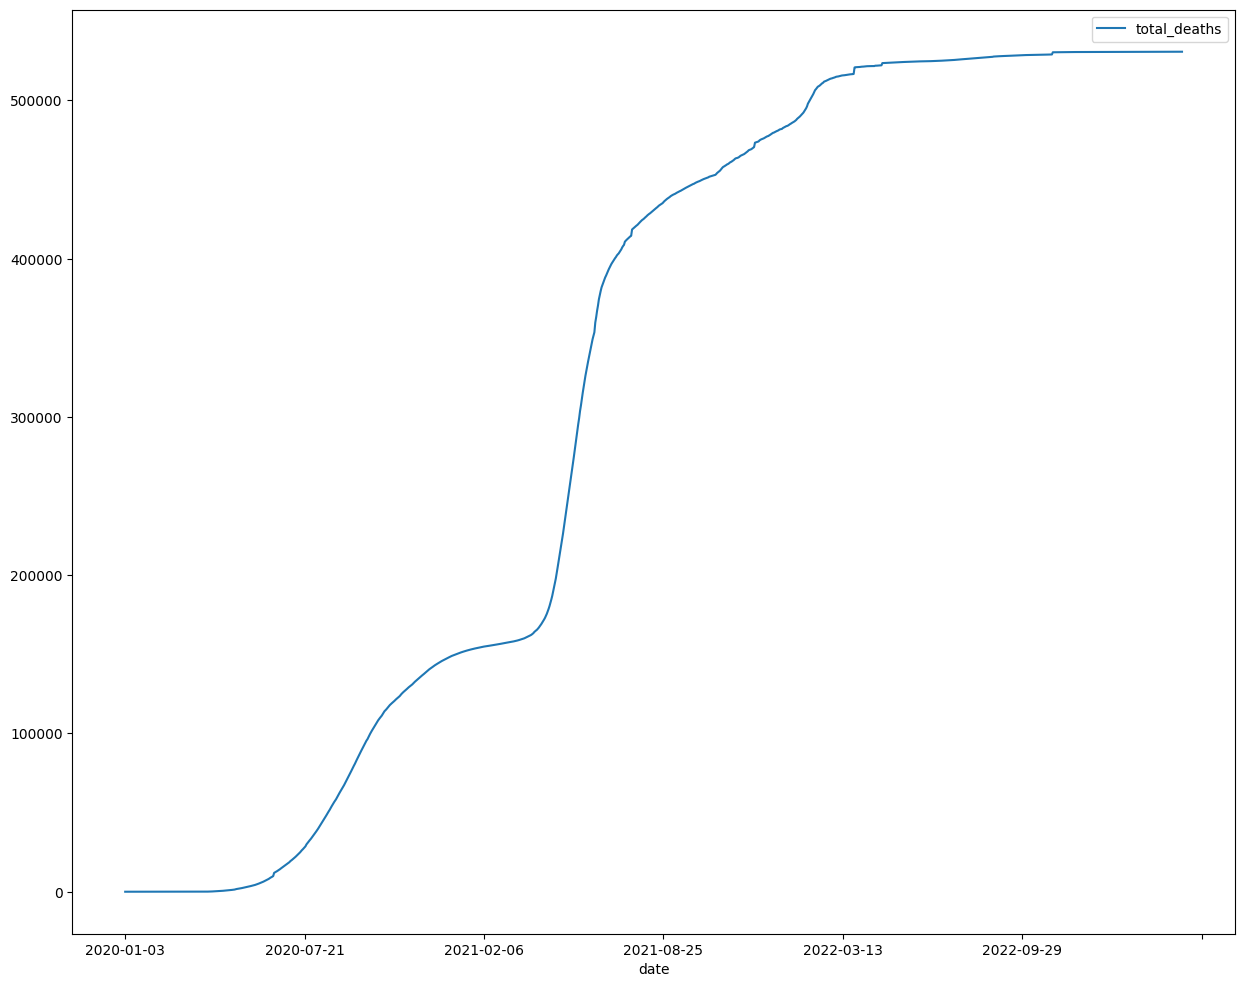

In [32]:
Main_Data.plot(x='date', y='total_deaths')

<AxesSubplot: xlabel='date'>

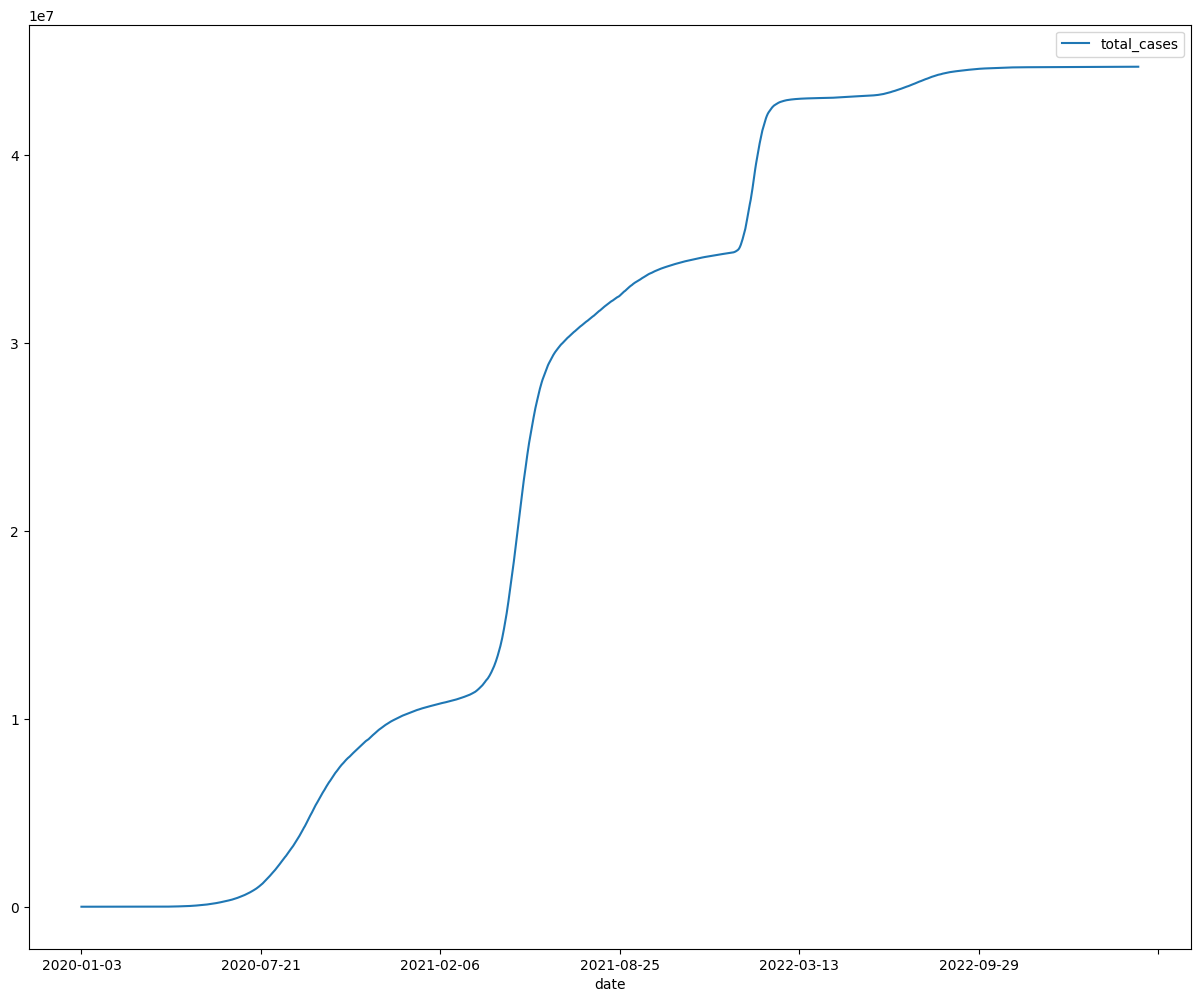

In [31]:
Main_Data.plot(x='date', y='total_cases')

<AxesSubplot: xlabel='date'>

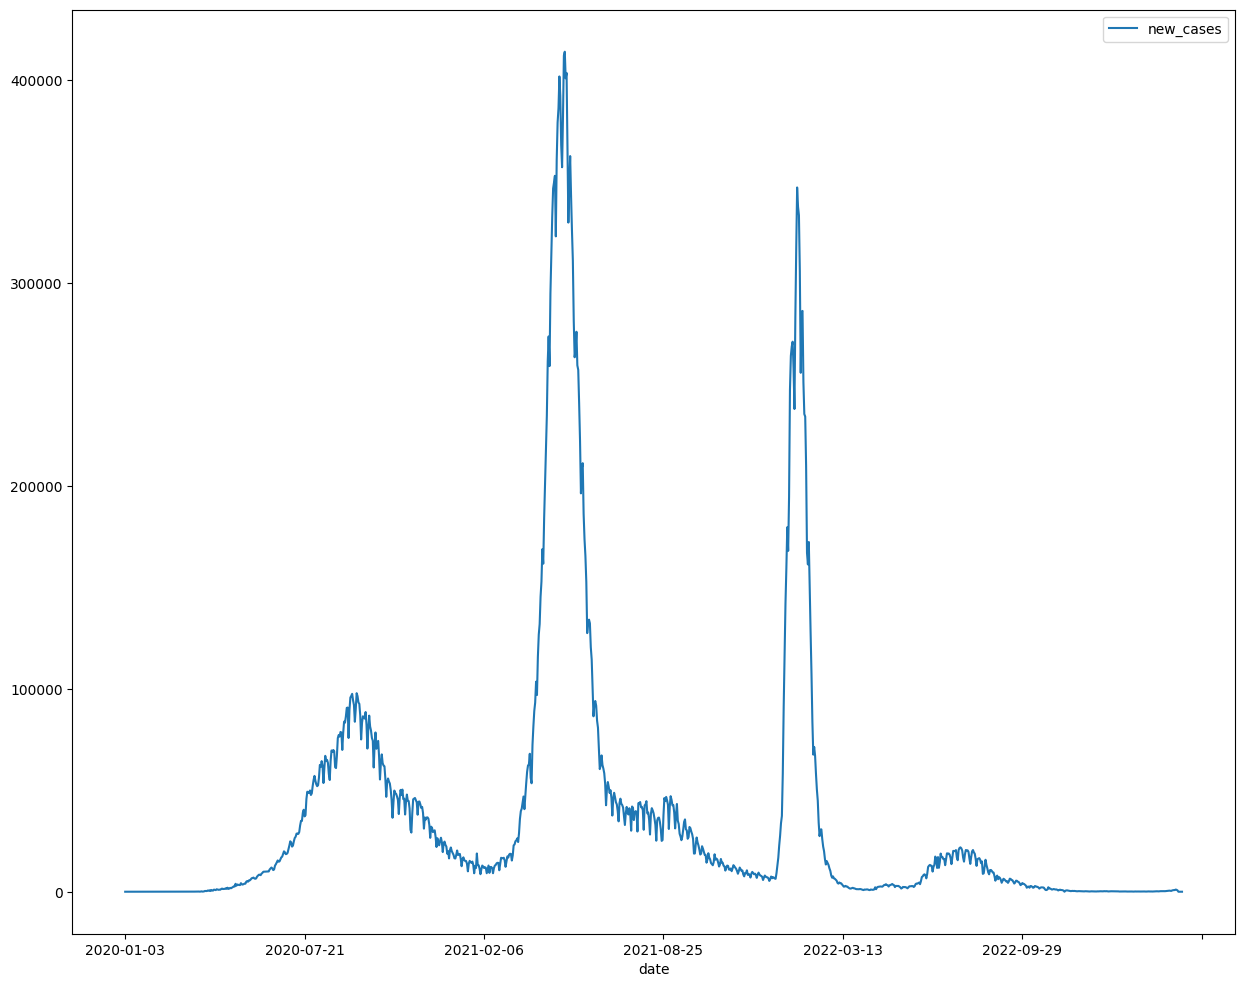

In [33]:
Main_Data.plot(x='date', y='new_cases')

<AxesSubplot: xlabel='date'>

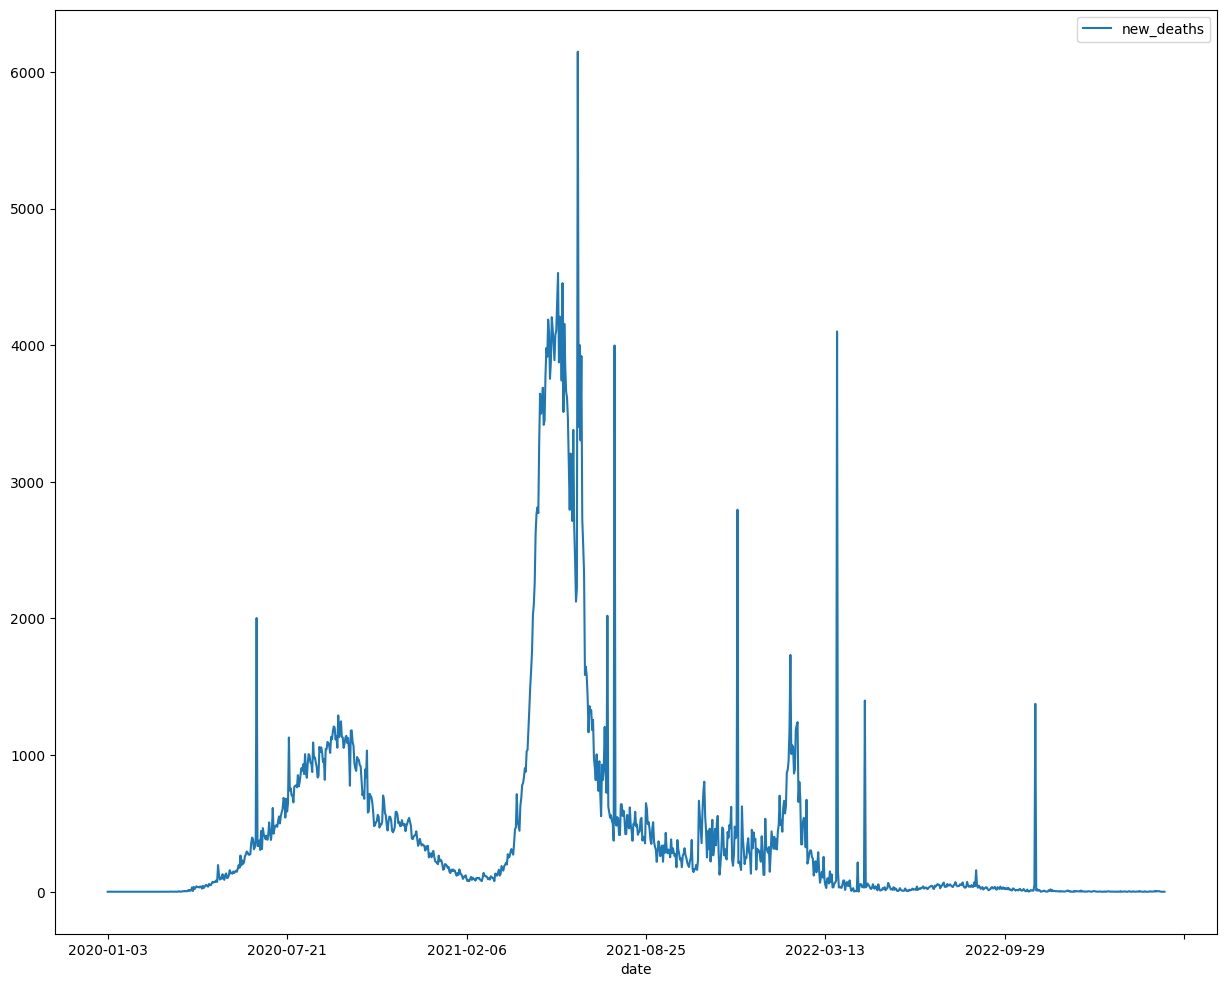

In [34]:
Main_Data.plot(x='date', y='new_deaths')

## Checking Data is Stationary or Not

### Dickey-Fuller Test

Null Hypothesis (H0): Series is stationary

Alternate Hypothesis(Ha): Series is non-stationary

checking the Null Hypothesis for level of significance of alpha=0.05

In [364]:
def showDickeyFullerTestOutput(column):
    dickey_fuller_test=statsmodels.tsa.stattools.adfuller(column,autolag='t-stat')
    result=pandas.DataFrame()
    result['index']=['Test Statistic','p-value','Lags Used','Number of Observations Used',"Critical_Value","maximized information criterion"]
    result['values']=dickey_fuller_test
    display(result)
    if dickey_fuller_test[1]>0.05:
        print("Data is Stationary")
    else:
        print("Data is Non-Stationary")

In [365]:
showDickeyFullerTestOutput(Main_Data['total_cases'])

,index,values
0,Test Statistic,-1.23355
1,p-value,0.659
2,Lags Used,22
3,Number of Observations Used,1156
4,Critical_Value,"{'1%': -3.4360194465416387, '5%': -2.864043453..."
5,maximized information criterion,2.274583


Data is Stationary


In [366]:
showDickeyFullerTestOutput(Main_Data['total_deaths'])

,index,values
0,Test Statistic,-1.404859
1,p-value,0.579945
2,Lags Used,19
3,Number of Observations Used,1159
4,Critical_Value,"{'1%': -3.4360047388340984, '5%': -2.864036965..."
5,maximized information criterion,1.784262


Data is Stationary


In [367]:
showDickeyFullerTestOutput(Main_Data['new_cases'])

,index,values
0,Test Statistic,-3.362906
1,p-value,0.01229
2,Lags Used,23
3,Number of Observations Used,1155
4,Critical_Value,"{'1%': -3.4360243661274414, '5%': -2.864045624..."
5,maximized information criterion,1.694142


Data is Non-Stationary


In [368]:
showDickeyFullerTestOutput(Main_Data['new_deaths'])

,index,values
0,Test Statistic,-3.025004
1,p-value,0.032624
2,Lags Used,18
3,Number of Observations Used,1160
4,Critical_Value,"{'1%': -3.435999853208029, '5%': -2.8640348101..."
5,maximized information criterion,1.806488


Data is Non-Stationary


## Non Stationary to Stationary Conversion

### Use of Rolling Concept

In [542]:
New_Data=Main_Data.rolling(200).min()

In [562]:
showDickeyFullerTestOutput(Main_Data['new_cases'][len(Main_Data)-200:])

,index,values
0,Test Statistic,-4.666603
1,p-value,0.000097
2,Lags Used,14
3,Number of Observations Used,185
4,Critical_Value,"{'1%': -3.4662005731940853, '5%': -2.877293277..."
5,maximized information criterion,2.420489


Data is Non-Stationary


In [551]:
New_Data

,total_cases,new_cases,total_deaths,new_deaths,population,life_expectancy
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1174,44456535.0,0.0,527991.0,0.0,1.417173e+09,69.66
1175,44462445.0,0.0,528007.0,0.0,1.417173e+09,69.66
1176,44466862.0,0.0,528030.0,0.0,1.417173e+09,69.66
1177,44472241.0,0.0,528057.0,0.0,1.417173e+09,69.66


In [550]:
showDickeyFullerTestOutput(New_Data['new_cases'].dropna())

,index,values
0,Test Statistic,-1.905211
1,p-value,0.329614
2,Lags Used,21
3,Number of Observations Used,958
4,Critical_Value,"{'1%': -3.4371943720994165, '5%': -2.864561673..."
5,maximized information criterion,1.711922


Data is Stationary


In [546]:
showDickeyFullerTestOutput(New_Data['new_deaths'].dropna())

,index,values
0,Test Statistic,-2.41765
1,p-value,0.136817
2,Lags Used,20
3,Number of Observations Used,959
4,Critical_Value,"{'1%': -3.43718721587049, '5%': -2.86455851778..."
5,maximized information criterion,2.33326


Data is Stationary


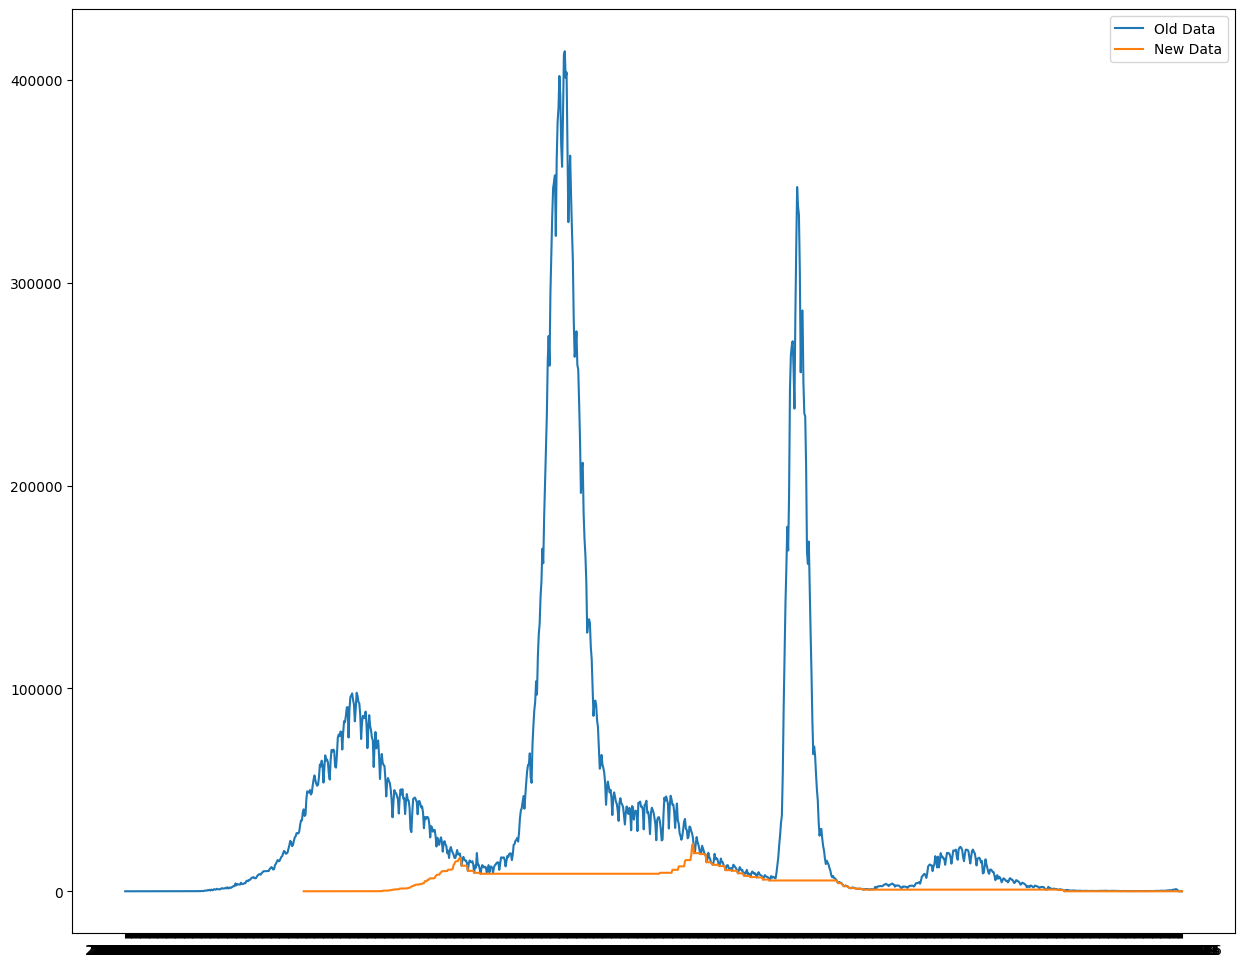

In [547]:
pyplot.plot(Main_Data['date'],Main_Data['new_cases'],label='Old Data')
pyplot.plot(Main_Data['date'],New_Data['new_cases'],label="New Data")
pyplot.legend()

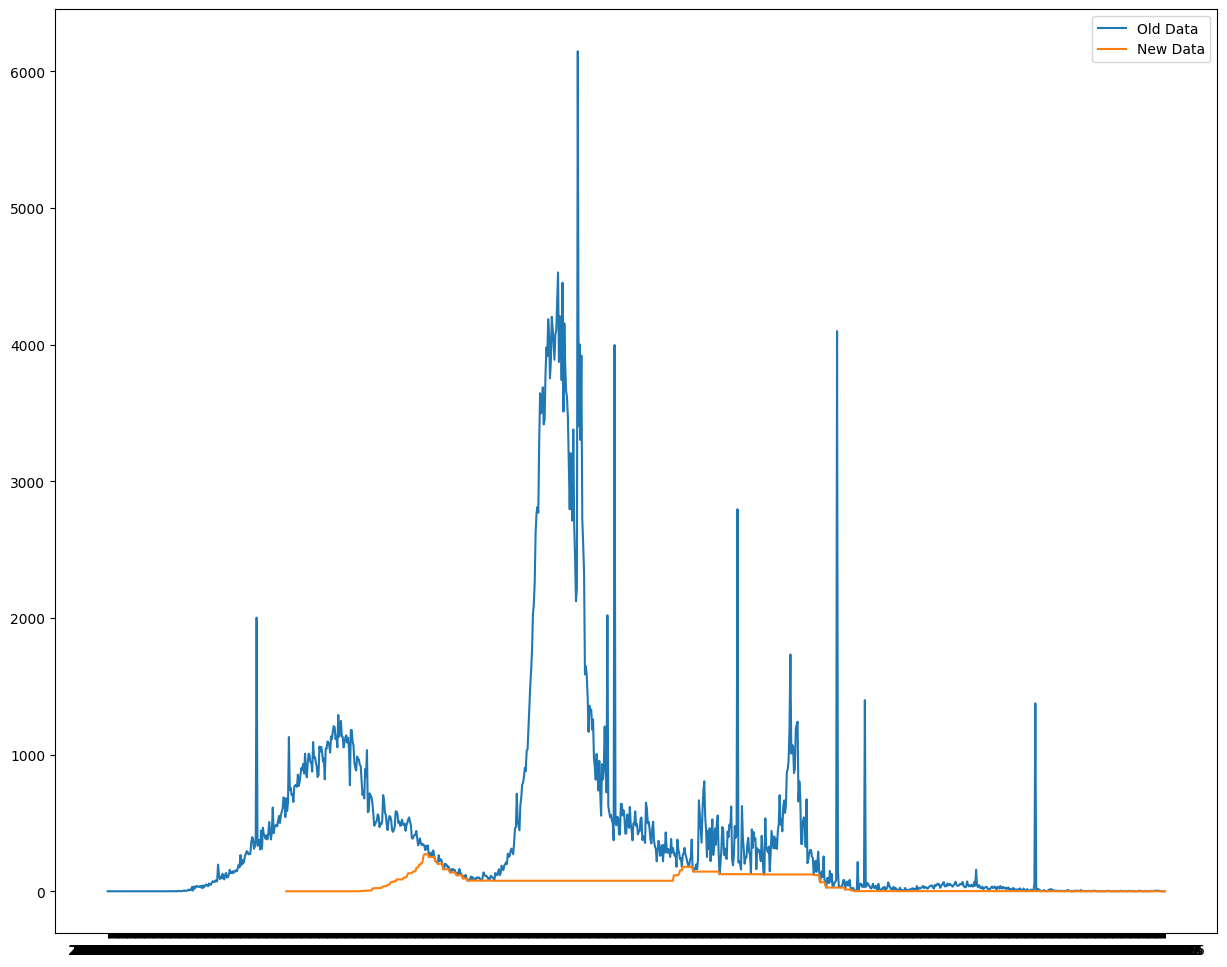

In [548]:
pyplot.plot(Main_Data['date'],Main_Data['new_deaths'],label="Old Data")
pyplot.plot(Main_Data['date'],New_Data['new_deaths'],label="New Data")
pyplot.legend()

## Plotting ACF and PACF

### ACF

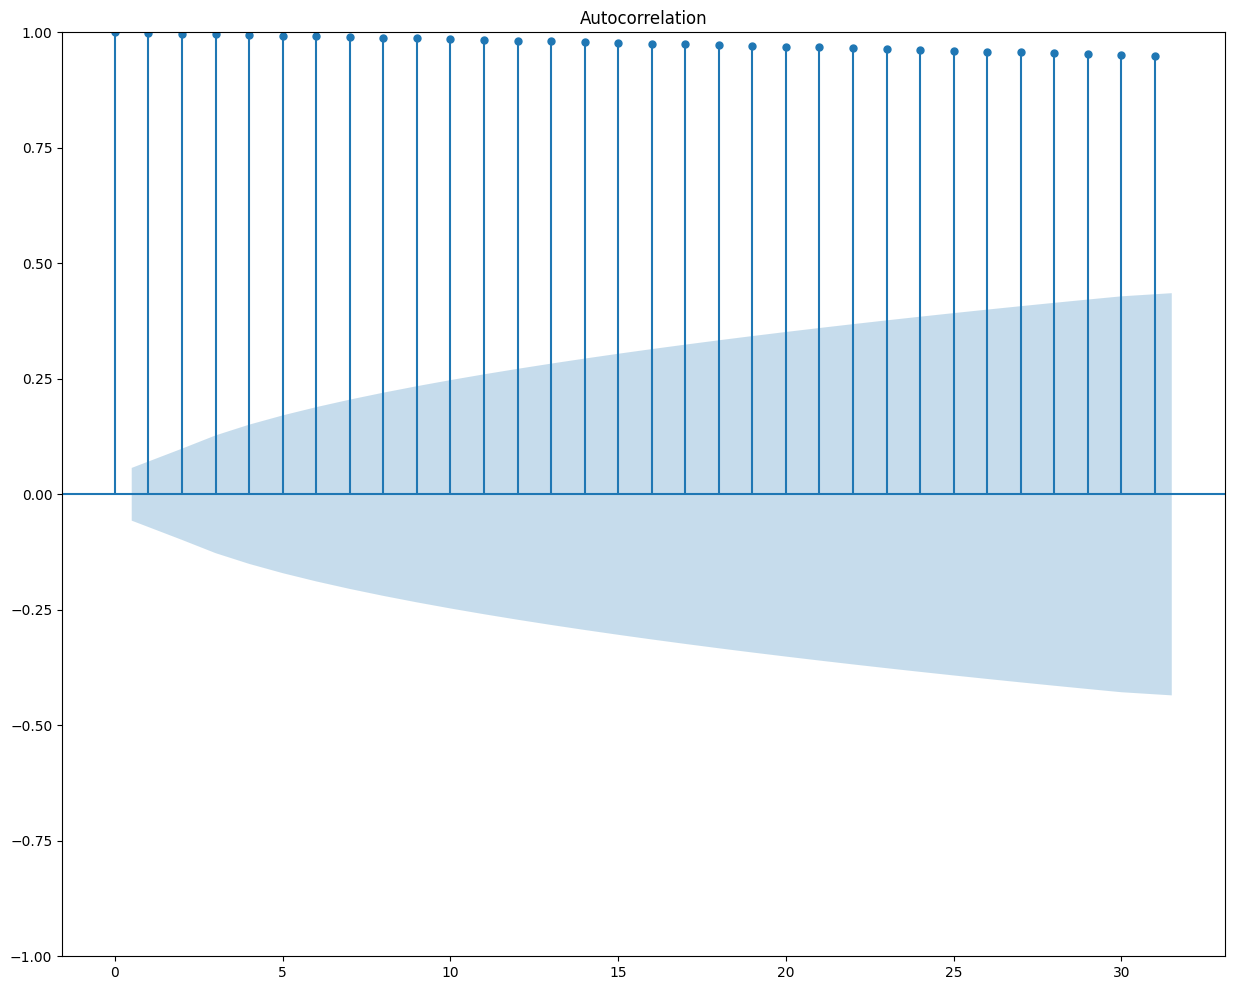

In [348]:
statsmodels.graphics.tsaplots.plot_acf(Main_Data['total_cases'])
pyplot.show()

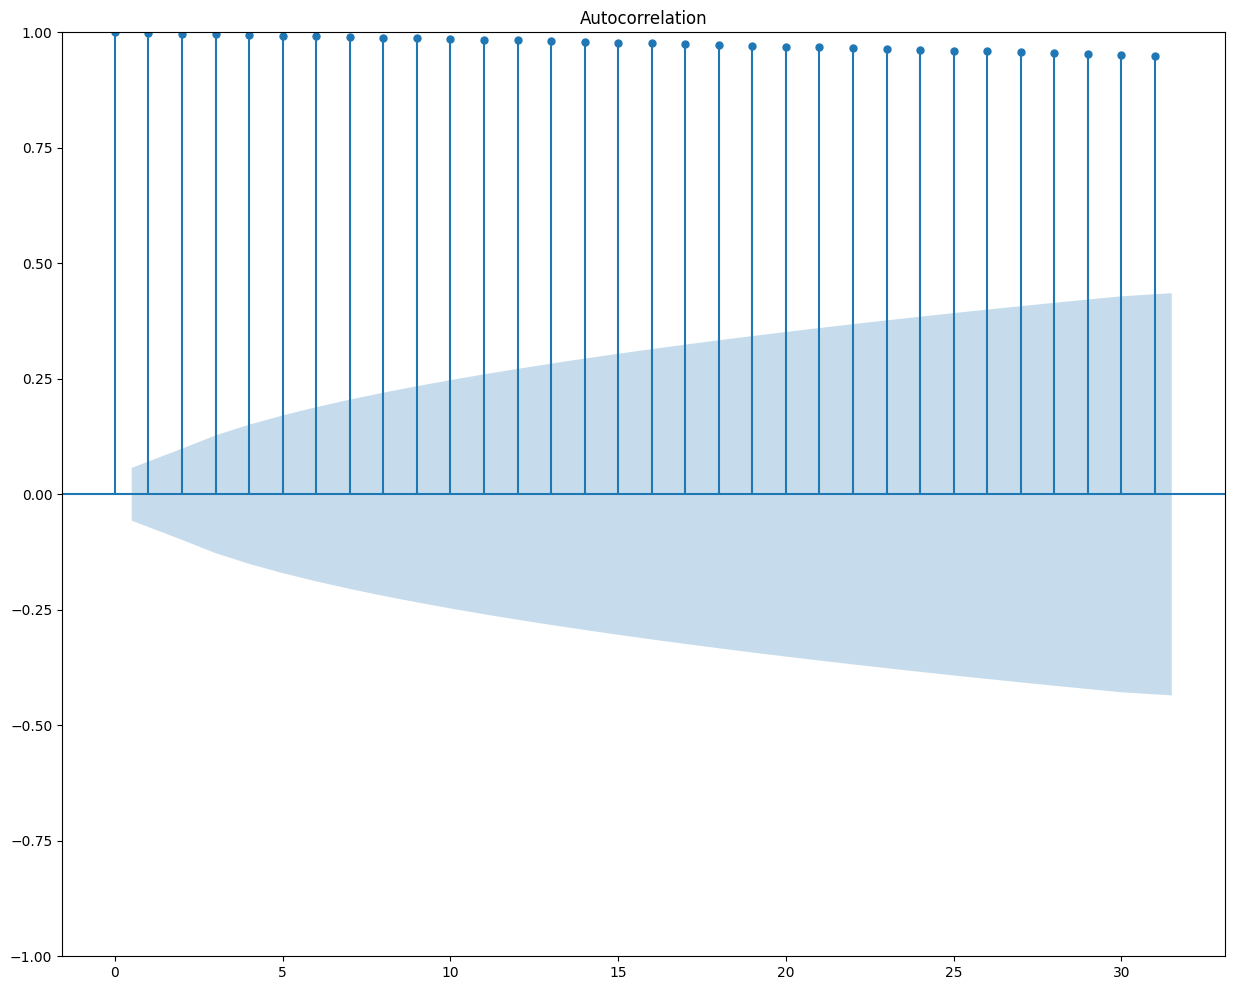

In [349]:
statsmodels.graphics.tsaplots.plot_acf(Main_Data['total_deaths'])
pyplot.show()

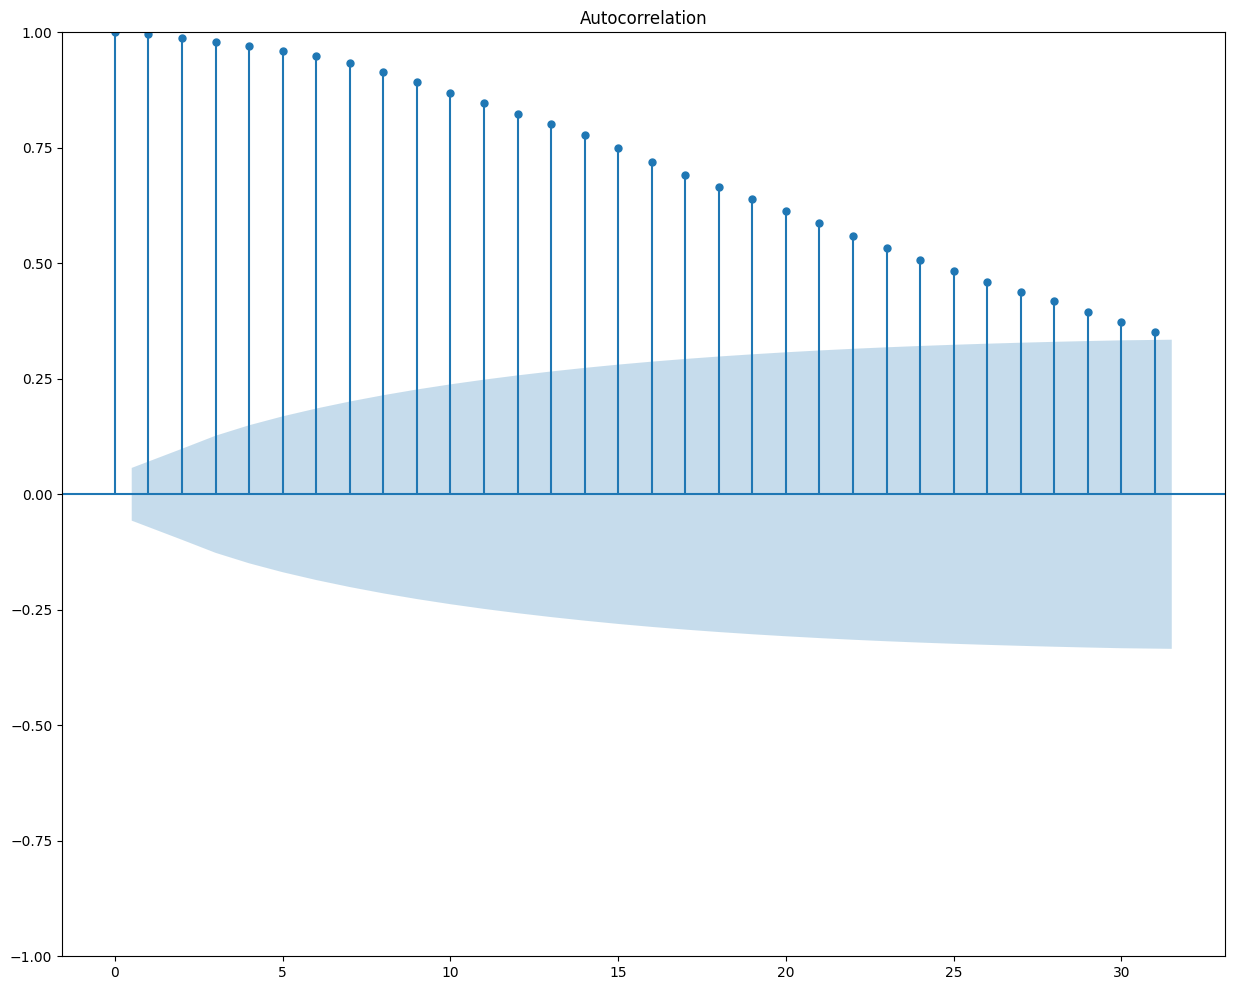

In [350]:
statsmodels.graphics.tsaplots.plot_acf(Main_Data['new_cases'])
pyplot.show()

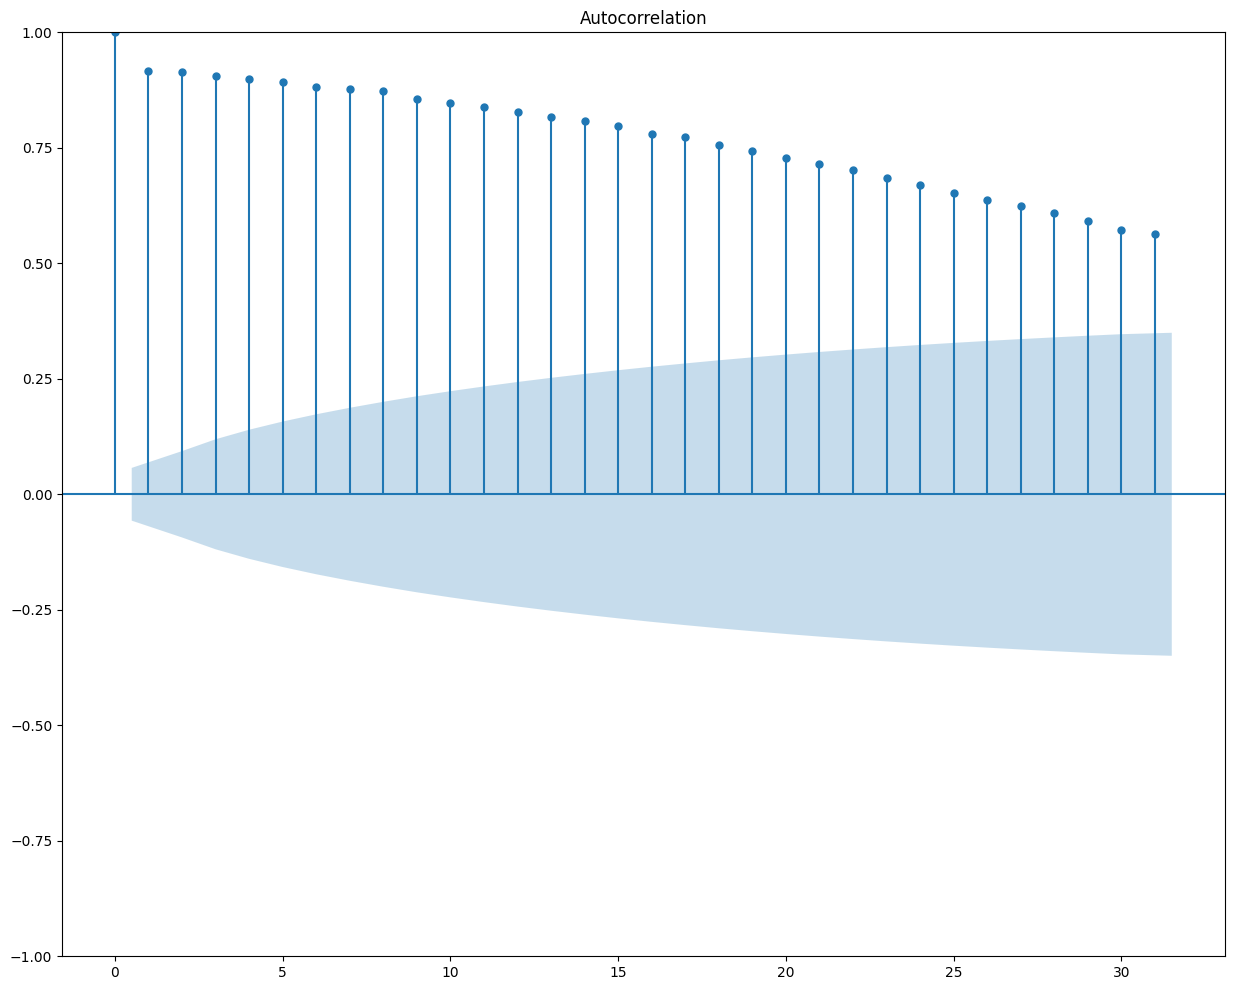

In [351]:
statsmodels.graphics.tsaplots.plot_acf(Main_Data['new_deaths'])
pyplot.show()

### PACF

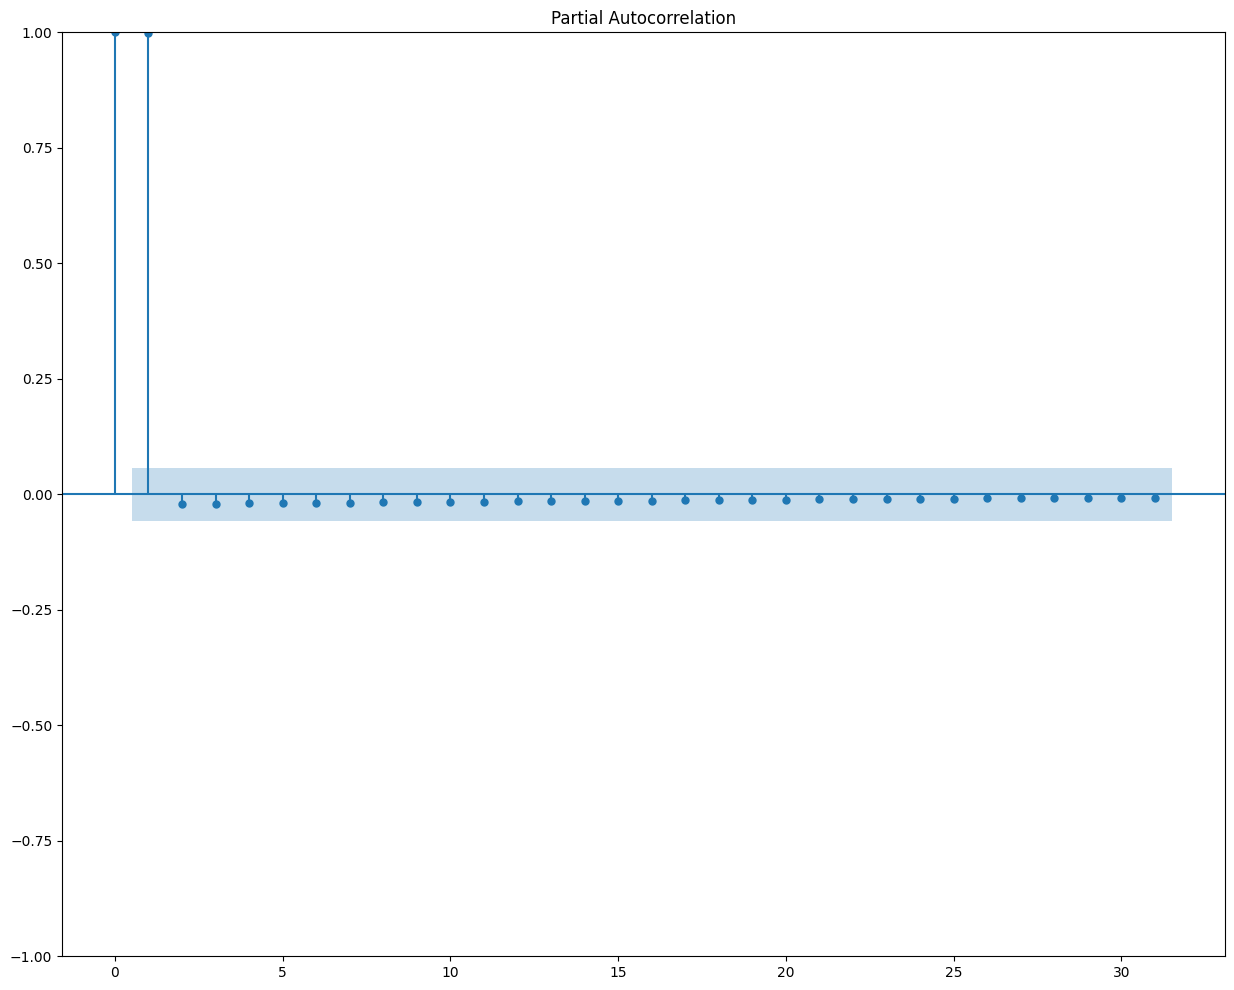

In [352]:
statsmodels.graphics.tsaplots.plot_pacf(Main_Data['total_cases'])
pyplot.show()

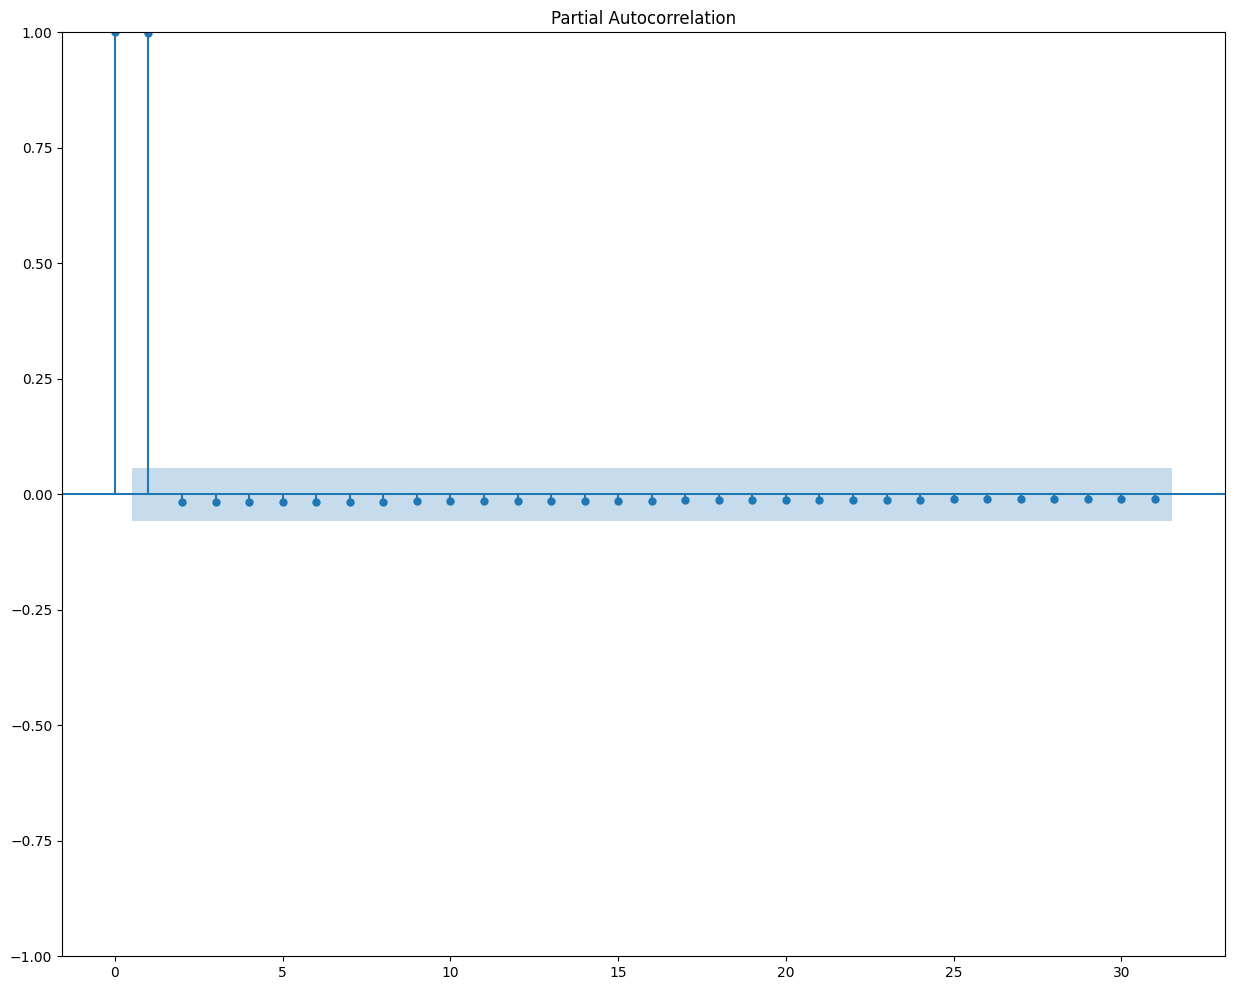

In [353]:
statsmodels.graphics.tsaplots.plot_pacf(Main_Data['total_deaths'])
pyplot.show()

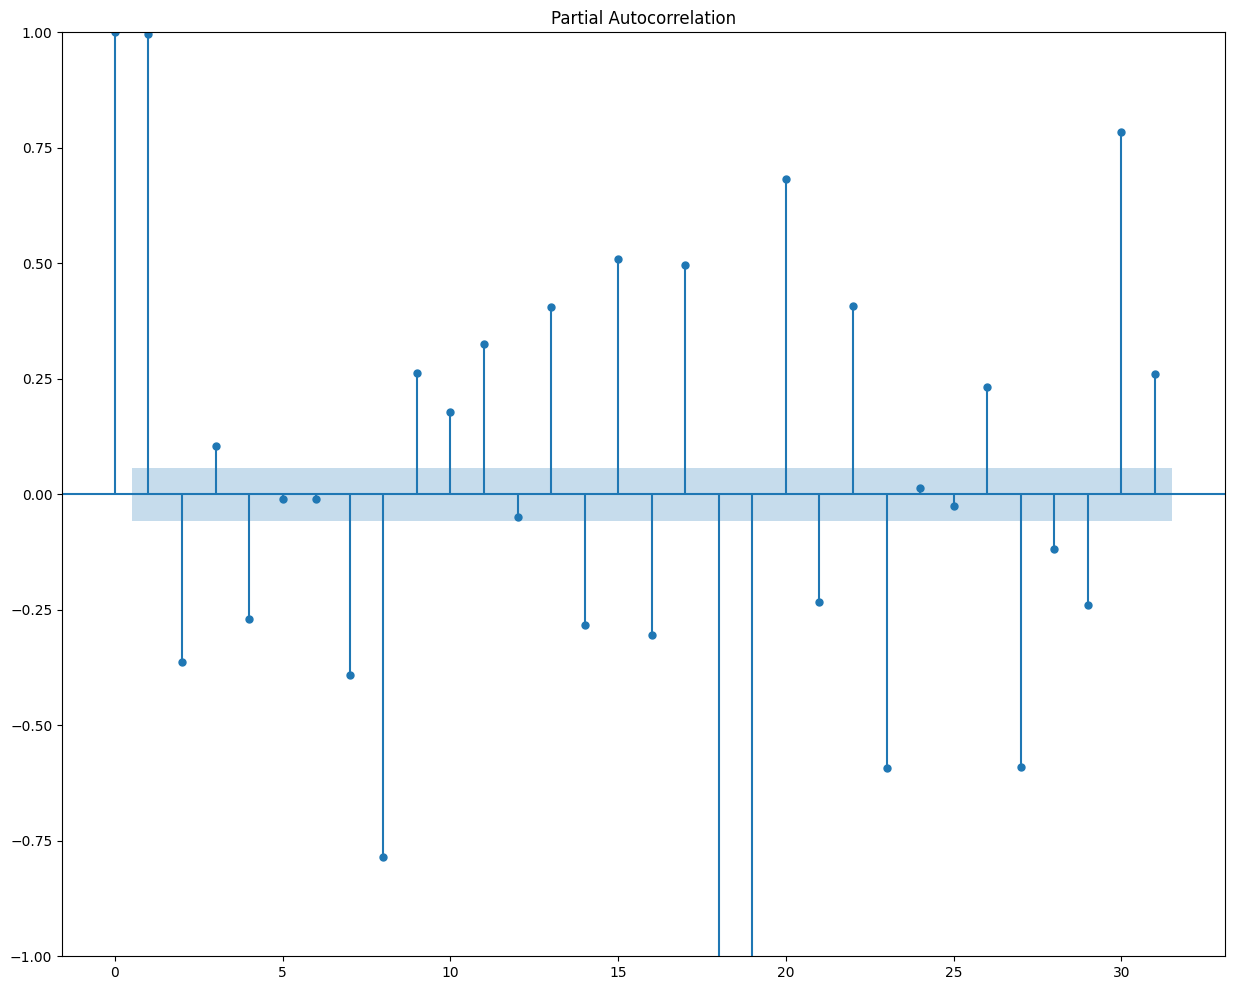

In [354]:
statsmodels.graphics.tsaplots.plot_pacf(Main_Data['new_cases'])
pyplot.show()

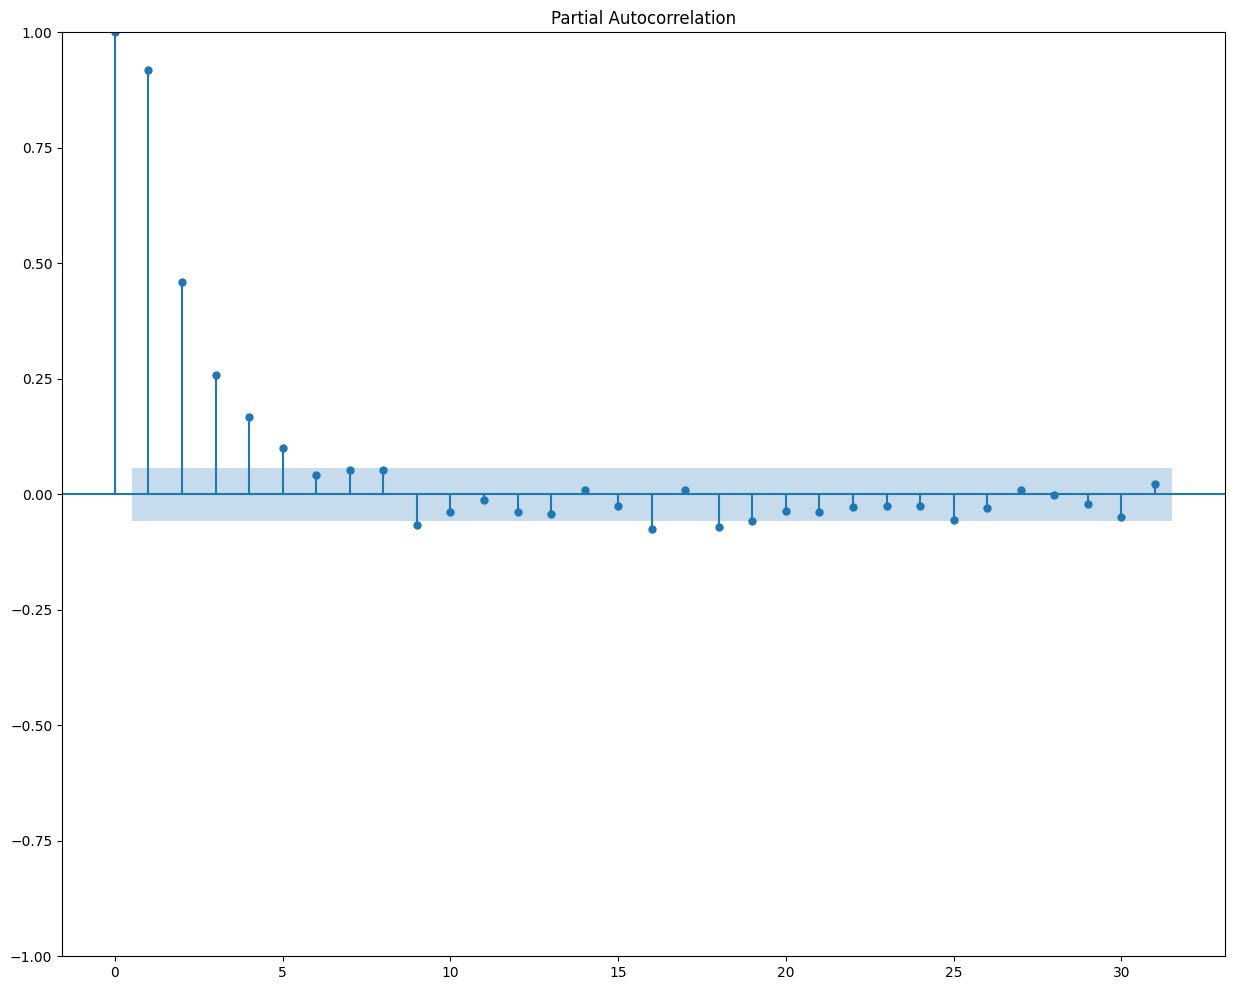

In [355]:
statsmodels.graphics.tsaplots.plot_pacf(Main_Data['new_deaths'])
pyplot.show()

# ARIMA Modelling

In [92]:
number_of_next_days=7
def returnNextdays(key):
    year=key[0:4]
    month=key[5:7]
    day=key[8:10]
    date=datetime.date(int(year),int(month),int(day))
    date=datetime.datetime.toordinal(date)
    date_range=[]
    for i in range(1,number_of_next_days+1):
        date_range.append(datetime.date.fromordinal(date+i).isoformat())
    return date_range
daterange=returnNextdays(list(Main_Data['date'])[-1])

In [555]:
def ModelingAndEvaluationWithForecastingForNextSevenDays(Main_Data,selected_column_name):
    Training_limit=int(0.95*len(Main_Data))
    Training_Dates=Main_Data[:Training_limit]['date']
    Testing_Dates=Main_Data[Training_limit:]['date']
    Training_Labels=Main_Data[:Training_limit][selected_column_name]
    Testing_Labels=Main_Data[Training_limit:][selected_column_name]
    order_of_forecasting_models1=(5,1,7)
    forcasting_data_features=Main_Data[['date',selected_column_name]]
    forcasting_train_data_features=Main_Data[['date',selected_column_name]][:Training_limit]
    forcasting_test_data_features=Main_Data[['date',selected_column_name]][Training_limit:]
    forcasting_data_features['date']=pandas.to_datetime(forcasting_data_features['date'])
    forcasting_train_data_features['date']=pandas.to_datetime(forcasting_train_data_features['date'])
    forcasting_test_data_features['date']=pandas.to_datetime(forcasting_test_data_features['date'])
    forcasting_data_features=forcasting_data_features.set_index('date')
    forcasting_train_data_features=forcasting_train_data_features.set_index('date')
    forcasting_test_data_features=forcasting_test_data_features.set_index('date')
    main_arima_model = ARIMA(forcasting_data_features,order=order_of_forecasting_models1)
    train_arima_model = ARIMA(forcasting_train_data_features,order=order_of_forecasting_models1)
    main_arima_fit_model=main_arima_model.fit()
    train_arima_fit_model=train_arima_model.fit()
    main_arima_fit_model_predicted=main_arima_fit_model.predict()
    train_arima_fit_model_predicted=train_arima_fit_model.predict()
    test_arima_predicted=train_arima_fit_model.forecast(steps=len(forcasting_test_data_features))
    arima_model_forcast=main_arima_fit_model.forecast(steps=7)
    print(f"Next 7 Days Forcasting of {selected_column_name}")
    print(arima_model_forcast)
    pyplot.figure('ARIMA model Forcasting')
    pyplot.plot(Main_Data['date'],Main_Data[selected_column_name],label='Original Data')
    pyplot.plot(Training_Dates,train_arima_fit_model_predicted,label='Train Data')
    pyplot.plot(Testing_Dates,test_arima_predicted,label='Test Data')
    pyplot.plot(daterange,arima_model_forcast,label='ARIMA Future Prediction')
    pyplot.xlabel('Date')
    pyplot.ylabel(selected_column_name)
    pyplot.legend()
    pyplot.show()
    print("ARIMA Forecasting")
    print("Trainig MAE: ",mean_absolute_error(train_arima_fit_model_predicted,Training_Labels),"\nTraining RMSE:",numpy.sqrt(mean_squared_error(train_arima_fit_model_predicted,Training_Labels)))
    print("Testing MAE:",mean_absolute_error(test_arima_predicted,Testing_Labels),"\nTesting RMSE:",numpy.sqrt(mean_squared_error(test_arima_predicted,Testing_Labels)))

Next 7 Days Forcasting of new_cases
2023-03-27   -128.007335
2023-03-28   -474.760223
2023-03-29   -835.902873
2023-03-30   -918.870288
2023-03-31   -826.428617
2023-04-01   -764.100867
2023-04-02   -742.684710
Freq: D, Name: predicted_mean, dtype: float64


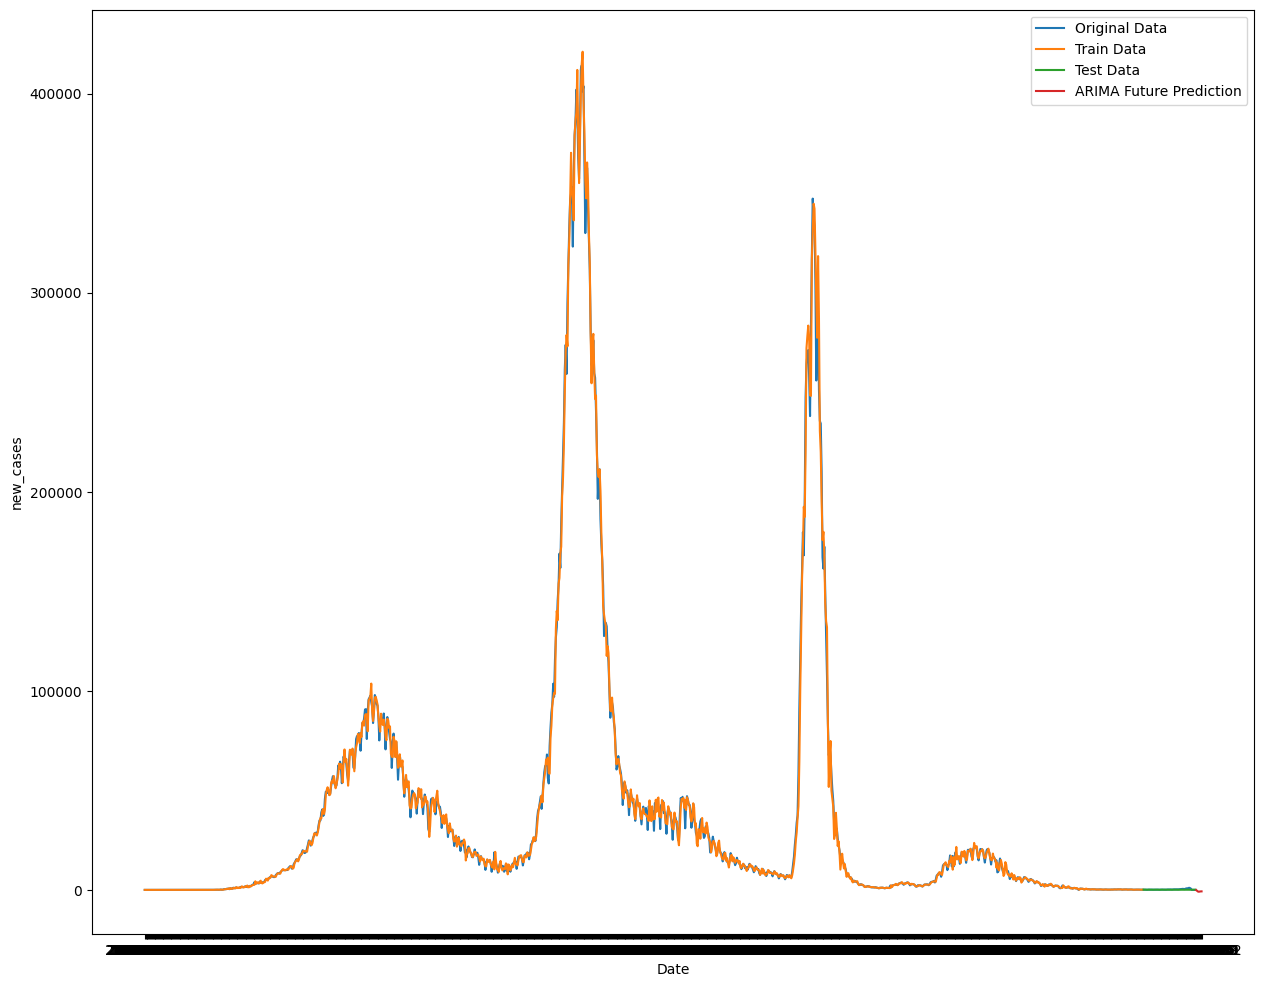

ARIMA Forecasting
Trainig MAE:  2123.020781622009 
Training RMSE: 4619.351764587616
Testing MAE: 176.02615625968537 
Testing RMSE: 292.09801674764793


In [556]:
ModelingAndEvaluationWithForecastingForNextSevenDays(Main_Data,'new_cases')

Next 7 Days Forcasting of new_deaths
2023-03-27    0.518364
2023-03-28    0.564416
2023-03-29    0.300282
2023-03-30    0.248243
2023-03-31    0.362738
2023-04-01    0.182010
2023-04-02    0.023160
Freq: D, Name: predicted_mean, dtype: float64


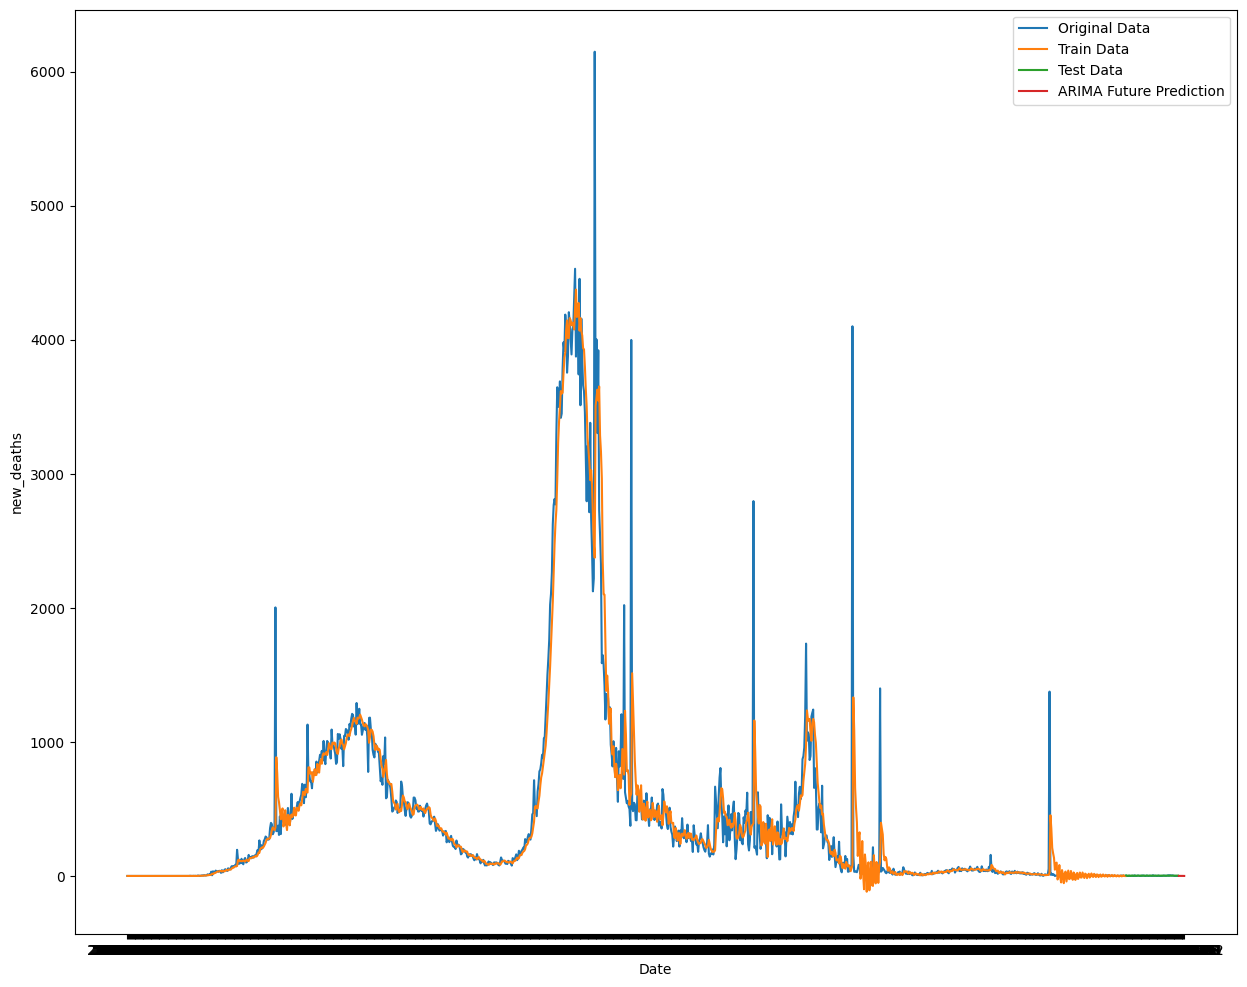

ARIMA Forecasting
Trainig MAE:  94.37809539610521 
Training RMSE: 275.14665839738564
Testing MAE: 1.6626075112902425 
Testing RMSE: 1.8793939546797704


In [557]:
ModelingAndEvaluationWithForecastingForNextSevenDays(Main_Data,'new_deaths')